
## Training an VGG image classifier


We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True,
                                          batch_size=128, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False,
                                         batch_size=128, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show some of the training images.


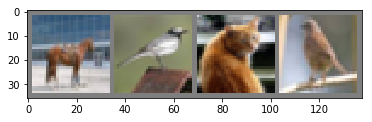

horse  bird   cat  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
import torch.nn as nn

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

net = VGG('VGG16')

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use_cuda')
    net.cuda()

use_cuda


### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

### 4. Train the network


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [6]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 128 == 127:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 128))
            running_loss = 0.0

print('Finished Training')

[1,   128] loss: 2.315
[1,   256] loss: 1.920
[1,   384] loss: 1.807
[2,   128] loss: 1.638
[2,   256] loss: 1.483
[2,   384] loss: 1.314
[3,   128] loss: 1.125
[3,   256] loss: 1.001
[3,   384] loss: 0.928
[4,   128] loss: 0.824
[4,   256] loss: 0.789
[4,   384] loss: 0.735
[5,   128] loss: 0.671
[5,   256] loss: 0.651
[5,   384] loss: 0.641
Finished Training


### 5. Test the network on the test data




In [7]:
correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in testloader:
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for (inputs, labels) in testloader:
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 89 %
Accuracy of  bird : 69 %
Accuracy of   cat : 70 %
Accuracy of  deer : 74 %
Accuracy of   dog : 54 %
Accuracy of  frog : 80 %
Accuracy of horse : 84 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %
